# Chapter 24

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# check if the libraries we need are installed
    
try:
    import modsim
except ImportError:
    !pip install modsimpy

In this chapter we model systems that involve rotating objects. In
general, rotation is complicated: in three dimensions, objects can
rotate around three axes; objects are often easier to spin around some
axes than others; and they may be stable when spinning around some axes but not others.

If the configuration of an object changes over time, it might become
easier or harder to spin, which explains the surprising dynamics of
gymnasts, divers, ice skaters, etc.

And when you apply a twisting force to a rotating object, the effect is often contrary to intuition. For an example, see this video on
gyroscopic precession <http://modsimpy.com/precess>.

In this chapter, we will not take on the physics of rotation in all its glory. Rather, we will focus on simple scenarios where all rotation and all twisting forces are around a single axis. In that case, we can treat some vector quantities as if they were scalars (in the same way that we sometimes treat velocity as a scalar with an implicit direction).

This approach makes it possible to simulate and analyze many interesting systems, but you will also encounter systems that would be better approached with the more general toolkit.

The fundamental ideas in this chapter and the next are **angular
velocity**, **angular acceleration**, **torque**, and **moment of
inertia**. If you are not already familiar with these concepts, I will
define them as we go along, and I will point to additional reading.

At the end of the next chapter, you will use these tools to simulate the behavior of a yo-yo (see <http://modsimpy.com/yoyo>). But we'll work our way up to it gradually, starting with toilet paper.

## The physics of toilet paper

As a simple example of a system with rotation, we'll simulate the
manufacture of a roll of toilet paper. Starting with a cardboard tube at the center, we will roll up 47 m of paper, the typical length of a roll of toilet paper in the U.S. (see <http://modsimpy.com/paper>).

![Diagram of a roll of toilet paper, showing change in paper length as a result of a small rotation, $d\theta$.](figs/paper_roll.pdf){height="2.5in"}

This figure shows a diagram of the system: $r$ represents
the radius of the roll at a point in time. Initially, $r$ is the radius of the cardboard core, $R_{min}$. When the roll is complete, $r$ is $R_{max}$.

I'll use $\theta$ to represent the total rotation of the roll in
radians. In the diagram, $d\theta$ represents a small increase in
$\theta$, which corresponds to a distance along the circumference of the roll of $r~d\theta$.

Finally, I'll use $y$ to represent the total length of paper that's been rolled. Initially, $\theta=0$ and $y=0$. For each small increase in $\theta$, there is a corresponding increase in $y$: 

$$dy = r~d\theta$$

If we divide both sides by a small increase in time, $dt$, we get a
differential equation for $y$ as a function of time.

$$\frac{dy}{dt} = r \frac{d\theta}{dt}$$ 

As we roll up the paper, $r$ increases, too. Assuming that $r$ increases by a fixed amount per revolution, we can write 

$$dr = k~d\theta$$ 

Where $k$ is an unknown constant we'll have to figure out. Again, we can divide both sides by $dt$ to get a differential equation in time:

$$\frac{dr}{dt} = k \frac{d\theta}{dt}$$ 

Finally, let's assume that $\theta$ increases at a constant rate of 10 rad/s (about 95 revolutions per minute): 

$$\frac{d\theta}{dt} = 10$$ 

This rate of change is called an **angular velocity**. Now we have a system of three differential equations we can use to simulate the system.

## Implementation

At this point we have a pretty standard process for writing simulations like this.

First we'll create a `Params` object with the parameters of the system:

In [2]:
from modsim import Params

params = Params(Rmin = 0.02,  # m 
                Rmax = 0.055, # m 
                L = 47,       # m 
                omega = 10,   # radian / s 
               )

`Rmin` and `Rmax` are the initial and final values for the radius, `r`.
`L` is the total length of the paper. `t_end` is the length of the
simulation in time, and `dt` is the time step for the ODE solver.

We use the `Params` object to make a `System` object:

In [3]:
from modsim import State, System

def make_system(params):
    init = State(theta = 0,   # radian
                 y = 0,       # m,
                 r = params.Rmin
                )
    
    k = estimate_k(params)

    return System(init=init, 
                  k=k,
                  omega = params.omega,
                  Rmin = params.Rmin,
                  Rmax = params.Rmax,
                  L = params.L,
                  t_end = 130,
                  num = 2000,
                 )

The initial state contains three variables, `theta`, `y`, and `r`.

`estimate_k` computes the parameter, `k`, that relates `theta` and `r`.
Here's how it works:

In [4]:
from numpy import pi

def estimate_k(params):
    Rmin, Rmax, L = params.Rmin, params.Rmax, params.L
    
    Ravg = (Rmax + Rmin) / 2
    Cavg = 2 * pi * Ravg
    revs = L / Cavg
    rads = 2 * pi * revs
    k = (Rmax - Rmin) / rads
    return k

`Ravg` is the average radius, half way between `Rmin` and `Rmax`, so
`Cavg` is the circumference of the roll when `r` is `Ravg`.

`revs` is the total number of revolutions it would take to roll up
length `L` if `r` were constant at `Ravg`. And `rads` is just `revs`
converted to radians.

Finally, `k` is the change in `r` for each radian of revolution. For
these parameters, `k` is about `2.8e-5` m/rad.

In [5]:
system = make_system(params)
system.init

theta    0.00
y        0.00
r        0.02
dtype: float64

In [6]:
system.k

2.7925531914893616e-05

Now we can use the differential equations from the previous section to
write a slope function:

In [7]:
def slope_func(t, state, system):
    theta, y, r = state
    k, omega = system.k, system.omega
    
    dydt = r * omega
    drdt = k * omega
    
    return omega, dydt, drdt

As usual, the slope function takes a `State` object, a time, and a
`System` object. The `State` object contains hypothetical values of
`theta`, `y`, and `r` at time `t`. The job of the slope function is to
compute the time derivatives of these values. The derivative of `theta` is angular velocity, which is often denoted `omega`.

And as usual, we should test the slope function with the initial conditions.

In [8]:
slope_func(0, system.init, system)

(10, 0.2, 0.0002792553191489362)

We'd like to stop the simulation when the length of paper on the roll is `L`. We can do that with an event function that passes through 0 when `y` equals `L`:

In [9]:
def event_func(t, state, system):
    theta, y, r = state
    return y - system.L

Now we can run the simulation like this:

In [10]:
from modsim import run_solve_ivp

results, details = run_solve_ivp(system, slope_func,
                                  events=event_func)
details.message

'A termination event occurred.'

### Plotting

Plotting `theta`

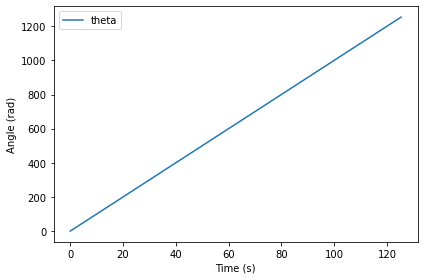

In [11]:
from modsim import decorate

def plot_theta(results):
    results.theta.plot(color='C0', label='theta')
    decorate(xlabel='Time (s)',
             ylabel='Angle (rad)')
    
plot_theta(results)

Plotting `y`

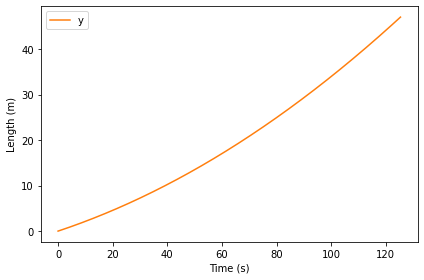

In [12]:
def plot_y(results):
    results.y.plot(color='C1', label='y')

    decorate(xlabel='Time (s)',
             ylabel='Length (m)')
    
plot_y(results)

Plotting `r`

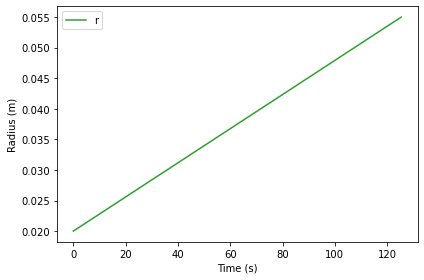

In [13]:
def plot_r(results):
    results.r.plot(color='C2', label='r')

    decorate(xlabel='Time (s)',
             ylabel='Radius (m)')
    
plot_r(results)

 `theta` grows linearly over time, as we should expect. As a result, `r` also grows linearly. But since the derivative of `y` depends on `r`, and `r` is increasing, `y` grows with increasing slope.

Because this system is so simple, it is almost silly to simulate it. As we'll see in the next section, it is easy enough to solve the
differential equations analytically. But it is often useful to start
with a simple simulation as a way of exploring and checking assumptions.

In [14]:
results.tail()

,theta,y,r
125.082541,1250.825413,46.862152,0.054930
125.145239,1251.452393,46.896598,0.054947
125.207937,1252.079373,46.931054,0.054965
125.270635,1252.706353,46.965522,0.054982
125.333333,1253.333333,47.000000,0.055000


The elapsed time is about 2 minutes, which is plausible.

In [15]:
t_final = results.index[-1]
t_final / 60

2.08888888888889

The final value of `y` is 47 meters, as expected.

In [51]:
final_state = results.iloc[-1] 
final_state.y, params.L

(47.0, 47)

The final value of radius is `Rmax`.

In [17]:
final_state.r, params.Rmax

(0.05500000000000002, 0.055)

And the total number of rotations is close to 200, which seems plausible.

In [52]:
radians = final_state.theta
rotations = radians / 2 / pi
rotations

199.47419534184226

## Animation

Here's a draw function that animates the results using `matplotlib` patches.

In [46]:
from matplotlib.patches import Circle, Arrow
from matplotlib.pyplot import gca, axis
from modsim import pol2cart

def draw_func(t, state):
    # get radius in mm
    theta, y, r = state
    radius = r
    
    # draw the paper
    circle = Circle([0, 0], radius)
    gca().add_patch(circle)
    
    # draw the core
    core = Circle([0, 0], params.Rmin, color='0.9')
    gca().add_patch(core)
    
    # draw the perimeter
    core = Circle([0, 0], params.Rmax, 
                  color='0.7', fill=False)
    gca().add_patch(core)
    
    # draw an arrow to show rotation
    dx, dy = pol2cart(theta, radius)
    arrow = Arrow(0, 0, dx, dy, color='C1', width=0.01)
    gca().add_patch(arrow)

    # make the aspect ratio 1
    decorate(xlim=[-0.1, 0.1],
             ylim=[-0.07, 0.07])

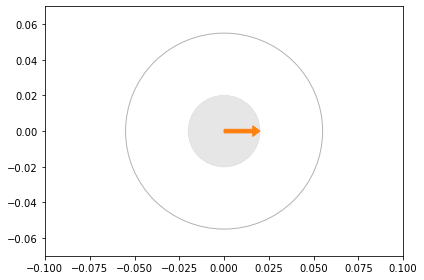

In [47]:
draw_func(0, system.init)

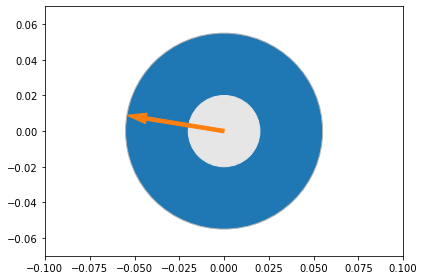

In [48]:
draw_func(t_final, final_state)

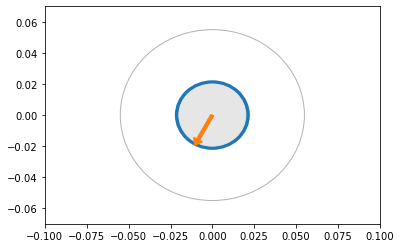

In [50]:
from modsim import animate

# animate(results, draw_func)

Now that we have a working simulation, it is also useful to do some analysis.

## Analysis

The differential equations in Section xx are simple enough that we can just solve them. Since angular velocity is constant: 

$$\frac{d\theta}{dt} = \omega$$ 

We can find $\theta$ as a function of time by integrating both sides:

$$\theta(t) = \omega t + C_1$$ 

With the initial condition $\theta(0)=0$, we find $C_1=0$. Similarly,

$$\frac{dr}{dt} = k \omega$$ 

So

$$r(t) = k \omega t + C_2$$ 

With the initial condition $r(0)=R_{min}$, we find $C_2=R_{min}$. Then we can plug the solution for $r$ into the equation for $y$: 

$$\begin{aligned}
\frac{dy}{dt} & = r \omega                      \\
              & = \left[ k \omega t + R_{min} \right] \omega \nonumber\end{aligned}$$
              
Integrating both sides yields:

$$y(t) = \left[ k \omega t^2 / 2 + R_{min} t \right] \omega + C_3$$ 

So $y$ is a parabola, as you might have guessed. With initial condition $y(0)=0$, we find $C_3=0$.

We can also use these equations to find the relationship between $y$ and $r$, independent of time, which we can use to compute $k$. Using a move we saw in Section xxx, I'll divide Equations 1 and
2, yielding

$$\frac{dr}{dy} = \frac{k}{r}$$ 

Separating variables yields

$$r~dr = k~dy$$ 

Integrating both sides yields 

$$r^2 / 2 = k y + C$$ 

When $y=0$, $r=R_{min}$, so $$C = \frac{1}{2} R_{min}^2$$ Solving for $y$, we have 

$$y = \frac{1}{2k} (r^2 - R_{min}^2)                 \label{eqn3}$$

When $y=L$, $r=R_{max}$; substituting in those values yields

$$L = \frac{1}{2k} (R_{max}^2 - R_{min}^2)$$ 

Solving for $k$ yields

$$k =  \frac{1}{2L} (R_{max}^2 - R_{min}^2)           \label{eqn4}$$

Plugging in the values of the parameters yields `2.8e-5` m/rad, the same as the "estimate" we computed in Section xxx. In this case the estimate turns out to be exact.

We can also see the relationship between `y` and `r`, which I derive analytically in the book.

## Summary

### Rolling paper

We'll start by loading the units we need.

In [22]:
radian = UNITS.radian
m = UNITS.meter
s = UNITS.second

NameError: name 'UNITS' is not defined

And creating a `Params` object with the system parameters

In [ ]:
params = Params(Rmin = 0.02 * m,
                Rmax = 0.055 * m,
                L = 47 * m,
                omega = 10 * radian / s,
                t_end = 130 * s,
                dt = 1*s)

The following function estimates the parameter `k`, which is the increase in the radius of the roll for each radian of rotation. 

In [ ]:
def estimate_k(params):
    """Estimates the parameter `k`.
    
    params: Params with Rmin, Rmax, and L
    
    returns: k in meters per radian
    """
    Rmin, Rmax, L = params.Rmin, params.Rmax, params.L
    
    Ravg = (Rmax + Rmin) / 2
    Cavg = 2 * pi * Ravg
    revs = L / Cavg
    rads = 2 * pi * revs
    k = (Rmax - Rmin) / rads
    return k

As usual, `make_system` takes a `Params` object and returns a `System` object.

In [ ]:
def make_system(params):
    """Make a system object.
    
    params: Params with Rmin, Rmax, and L
    
    returns: System with init, k, and ts
    """
    init = State(theta = 0 * radian,
                 y = 0 * m,
                 r = params.Rmin)
    
    k = estimate_k(params)

    return System(params, init=init, k=k)

Testing `make_system`

In [ ]:
system = make_system(params)

In [ ]:
system.init

Now we can write a slope function based on the differential equations

$\omega = \frac{d\theta}{dt} = 10$

$\frac{dy}{dt} = r \frac{d\theta}{dt}$

$\frac{dr}{dt} = k \frac{d\theta}{dt}$


In [ ]:
def slope_func(state, t, system):
    """Computes the derivatives of the state variables.
    
    state: State object with theta, y, r
    t: time
    system: System object with r, k
    
    returns: sequence of derivatives
    """
    theta, y, r = state
    k, omega = system.k, system.omega
    
    dydt = r * omega
    drdt = k * omega
    
    return omega, dydt, drdt

Testing `slope_func`

In [ ]:
slope_func(system.init, 0, system)

We'll use an event function to stop when `y=L`.

In [ ]:
def event_func(state, t, system):
    """Detects when we've rolled length `L`.
    
    state: State object with theta, y, r
    t: time
    system: System object with L
    
    returns: difference between `y` and `L`
    """
    theta, y, r = state
    
    return y - system.L

In [ ]:
event_func(system.init, 0, system)

Now we can run the simulation.

In [ ]:
results, details = run_solve_ivp(system, slope_func, events=event_func)
details

And look at the results.

**Exercise:** Run the simulation again with a smaller step size to smooth out the animation.

### Exercises

**Exercise:** Since we keep `omega` constant, the linear velocity of the paper increases with radius.  Use `gradient` to estimate the derivative of `results.y`.  What is the peak linear velocity?

In [ ]:
# Solution

dydt = gradient(results.y);

In [ ]:
plot(dydt, label='dydt')
decorate(xlabel='Time (s)',
         ylabel='Linear velocity (m/s)')

In [ ]:
# Solution

linear_velocity = get_last_value(dydt) * m/s

Now suppose the peak velocity is the limit; that is, we can't move the paper any faster than that.

Nevertheless, we might be able to speed up the process by keeping the linear velocity at the maximum all the time.

Write a slope function that keeps the linear velocity, `dydt`, constant, and computes the angular velocity, `omega`, accordingly.

Run the simulation and see how much faster we could finish rolling the paper.

In [ ]:
# Solution

def slope_func(state, t, system):
    """Computes the derivatives of the state variables.
    
    state: State object with theta, y, r
    t: time
    system: System object with r, k
    
    returns: sequence of derivatives
    """
    theta, y, r = state
    k, omega = system.k, system.omega
    
    dydt = linear_velocity
    omega = dydt / r
    drdt = k * omega
    
    return omega, dydt, drdt

In [ ]:
# Solution

slope_func(system.init, 0, system)

In [ ]:
# Solution

results, details = run_solve_ivp(system, slope_func, events=event_func)
details

In [ ]:
# Solution

t_final = get_last_label(results) * s

In [ ]:
# Solution

plot_three(results)